In [1]:
import sys
sys.path.append('../../src')

from common import common, transform, json
from tracker import main as tr
from individual_activity import main as ia
from group_activity import main as ga
from display.display import display
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Indivisual Activity をロード

In [2]:
room_num = '09'
date = '20210304'
name_train = 'pass1'

In [3]:
individual_activity_json_train = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name_train))
field_path = os.path.join(
    common.data_dir, 'field.png')

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo_train = transform.Homography(p_video, p_field, field_raw.shape)

In [5]:
individual_activity_data_train = json.load(individual_activity_json_train)

In [6]:
from common.json import IA_FORMAT
from individual_activity.individual_activity import IndividualActivity

def make_individuals(datas, homo):
    individuals = {}
    for data in datas:
        label = data[IA_FORMAT[0]]
        frame_num = data[IA_FORMAT[1]]
        keypoints = np.array(data[IA_FORMAT[2]])

        if label not in individuals:
            ia = IndividualActivity(label, frame_num, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.keypoints_lst.append(keypoints)
        for f in IA_FORMAT[3:]:
            ia.indicator_dict[f].append(data[f])
            
    return individuals

In [7]:
individuals_train = make_individuals(individual_activity_data_train, homo_train)

# 特徴量抽出とデータ生成

In [8]:
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT

def extract_features(label1, label2, frame_num, individuals):
    individual1 = individuals[label1]
    pos1 = individual1.get_data('position', frame_num)
    body1 = individual1.get_data('body_vector', frame_num)
    arm1 = individual1.get_data('arm', frame_num)
    if pos1 is None or body1 is None or arm1 is None:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_data('position', frame_num)
    body2 = individual2.get_data('body_vector', frame_num)
    arm2 = individual2.get_data('arm', frame_num)
    if pos2 is None or body2 is None or arm2 is None:
        return None
    
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig'])
    
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_sim = np.average([p1_sim, p2_sim])
    
    arm_ave = np.average([arm1, arm2])

    return [distance_prob, body_sim, arm_ave]
#     return [distance_prob, p1p2_sim, arm1, arm2]
#     return [distance_prob, p1_sim, p2_sim, arm_ave]
#     return [distance_prob, p1_sim, p2_sim, arm1, arm2]

columns = ['distance', 'body similarity', 'arm average']
# columns = ['distance', 'body similarity', 'p1 arm', 'p2 arm']
# columns = ['distance', 'p1 cos similarity', 'p2 cos similarity', 'arm average']
# columns = ['distance', 'p1 cos similarity', 'p2 cos similarity', 'p1 arm', 'p2 arm']

In [9]:
# train data
csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name_train))
csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

train_x_dict = {}
train_y_dict = {}
for row in csv_data:
    features = extract_features(row[1], row[2], row[0], individuals_train)
    key = str(row[1]) + str(row[2])
    
    if key not in train_x_dict:
        train_x_dict[key] = []
        train_y_dict[key] = []
        
    if features is not None:
        train_x_dict[key].append(features)
        train_y_dict[key].append(row[3])

In [10]:
train_x_dict['01'][0]

[0.9231778681638858, -0.5104024662218308, 0.26160166510262584]

# 分布をプロット

(0.0, 1.0)

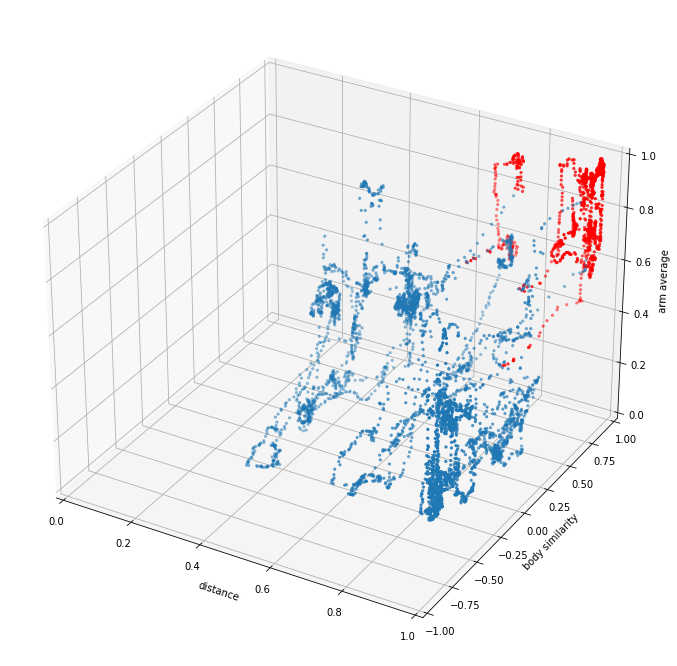

In [11]:
# データを整形
train_x = []
train_y = []
for x, y in zip(train_x_dict.values(), train_y_dict.values()):
    train_x += x
    train_y += y

x_true = np.array(train_x)[np.where(np.array(train_y) == 1)].T
x_false = np.array(train_x)[np.where(np.array(train_y) == 0)].T

# 分布をプロット
def set_ax(ax, column_i, column_j, title):
    ax.set_title(title)
    ax.set_xlabel(column_i)
    ax.set_ylabel(column_j)
    if 'similarity' in column_i:
        ax.set_xlim((-1, 1))
    else:
        ax.set_xlim((0, 1))
        
    if 'similarity' in column_j:
        ax.set_ylim((-1, 1))
    else:
        ax.set_ylim((0, 1))

n = int(len(columns) * (len(columns) - 1) / 2)  # 組み合わせ: len(columns) C 2

# fig = plt.figure(figsize=(12, n * 6))
# ax_count = 1
# for i in range(len(columns) - 1):
#     for j in range(i + 1, len(columns)):
#         ax = fig.add_subplot(n, 2, ax_count * 2 - 1)
#         ax.scatter(x_false[i], x_false[j])
#         set_ax(ax, columns[i], columns[j], 'false datas')
        
#         ax = fig.add_subplot(n, 2, ax_count * 2)
#         ax.scatter(x_true[i], x_true[j], color='red')
#         set_ax(ax, columns[i], columns[j], 'true datas')
        
#         ax_count += 1
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_false[0], x_false[1], x_false[2], marker='.')
ax.scatter(x_true[0], x_true[1], x_true[2], color='red', marker='.')
ax.set_xlabel('distance')
ax.set_xlim((0, 1))
ax.set_ylabel('body similarity')
ax.set_ylim((-1, 1))
ax.set_zlabel('arm average')
ax.set_zlim((0, 1))

# 学習・検証

In [12]:
from sklearn.svm import SVC

from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [13]:
train_x = []
train_y = []
for x, y in zip(train_x_dict.values(), train_y_dict.values()):
    train_x += x
    train_y += y
    
# train_x = scale(train_x)

In [14]:
model = SVC(C=10, gamma=0.09)

model.fit(train_x, train_y)

SVC(C=10, gamma=0.09)

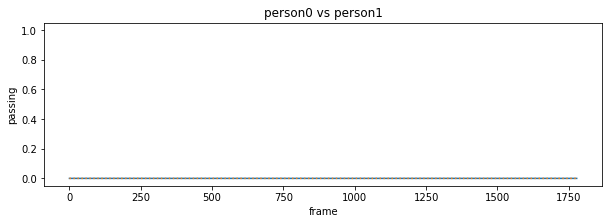

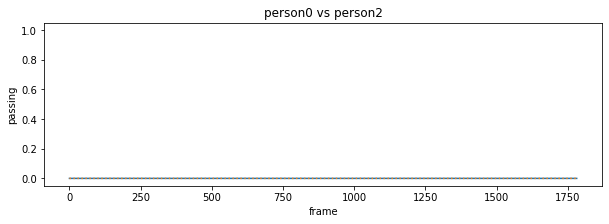

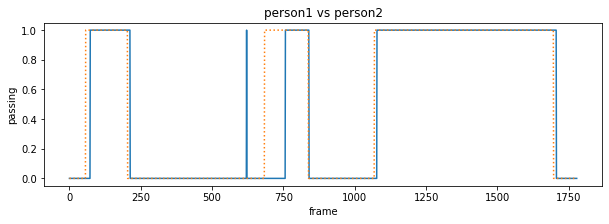

In [15]:
for persons, x, y in zip(train_x_dict.keys(), train_x_dict.values(), train_y_dict.values()):
    pred = model.predict(x)
    plt.figure(figsize=(10, 3))
    plt.plot(pred)
    plt.plot(y, linestyle=':')
    plt.ylim((-0.05, 1.05))
    plt.xlabel('frame')
    plt.ylabel('passing')
    plt.title('person{0} vs person{1}'.format(persons[0], persons[1]))
    plt.show()

accuracy: 0.978
precision: 0.974
recall: 0.895


<AxesSubplot:>

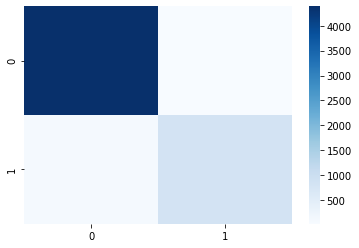

In [16]:
pred = model.predict(train_x)

print('accuracy: {:.3f}'.format(accuracy_score(train_y, pred)))
print('precision: {:.3f}'.format(precision_score(train_y, pred)))
print('recall: {:.3f}'.format(recall_score(train_y, pred)))

cm = confusion_matrix(train_y, pred)
sns.heatmap(cm, cmap='Blues')

# テスト
## テスト1

In [17]:
name_test1 = 'pass3'

In [18]:
individual_activity_json_test1 = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name_test1))
field_path = os.path.join(
    common.data_dir, 'field.png')

In [19]:
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo_test1 = transform.Homography(p_video, p_field, field_raw.shape)

In [20]:
individual_activity_data_test1 = json.load(individual_activity_json_test1)

In [21]:
individuals_test1 = make_individuals(individual_activity_data_test1, homo_test1)

In [22]:
# test data
csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name_test1))
csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

test_x_dict1 = {}
test_y_dict1 = {}
for row in csv_data:
    features = extract_features(row[1], row[2], row[0], individuals_test1)
    key = str(row[1]) + str(row[2])
    
    if key not in test_x_dict1:
        test_x_dict1[key] = []
        test_y_dict1[key] = []
        
    if features is not None:
        test_x_dict1[key].append(features)
        test_y_dict1[key].append(row[3])

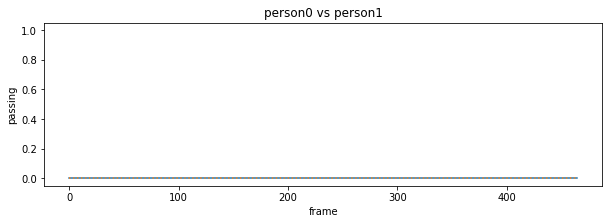

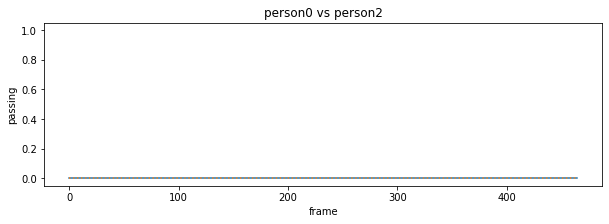

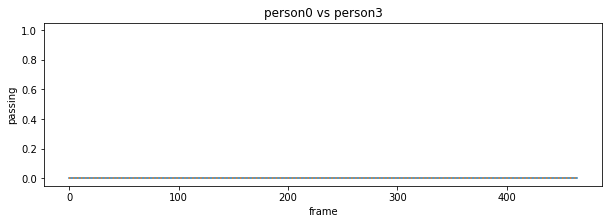

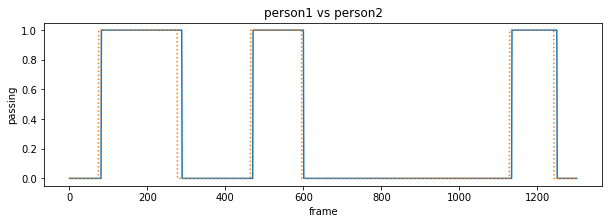

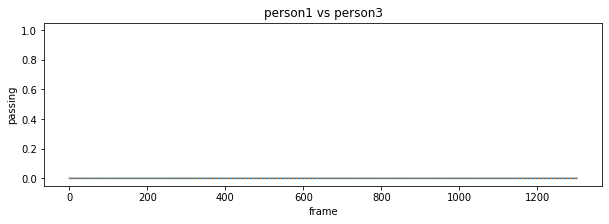

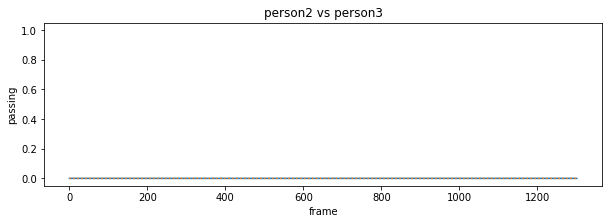

In [23]:
# test1
test1_pred = []
for persons, x, y in zip(test_x_dict1.keys(), test_x_dict1.values(), test_y_dict1.values()):
#     x = scale(x)
    pred = model.predict(x)
    test1_pred += pred.tolist()
    plt.figure(figsize=(10, 3))
    plt.plot(pred)
    plt.plot(y, linestyle=':')
    plt.ylim((-0.05, 1.05))
    plt.xlabel('frame')
    plt.ylabel('passing')
    plt.title('person{0} vs person{1}'.format(persons[0], persons[1]))
    plt.show()

accuracy: 0.992
precision: 0.945
recall: 0.957


<AxesSubplot:>

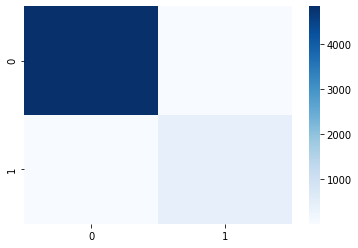

In [24]:
test_x1 = []
test_y1 = []
for x, y in zip(test_x_dict1.values(), test_y_dict1.values()):
    test_x1 += x
    test_y1 += y

pred = model.predict(test_x1)

print('accuracy: {:.3f}'.format(accuracy_score(test_y1, pred)))
print('precision: {:.3f}'.format(precision_score(test_y1, pred)))
print('recall: {:.3f}'.format(recall_score(test_y1, pred)))

cm = confusion_matrix(test_y1, pred)
sns.heatmap(cm, cmap='Blues')

Text(0.5, 0.92, 'Prediction')

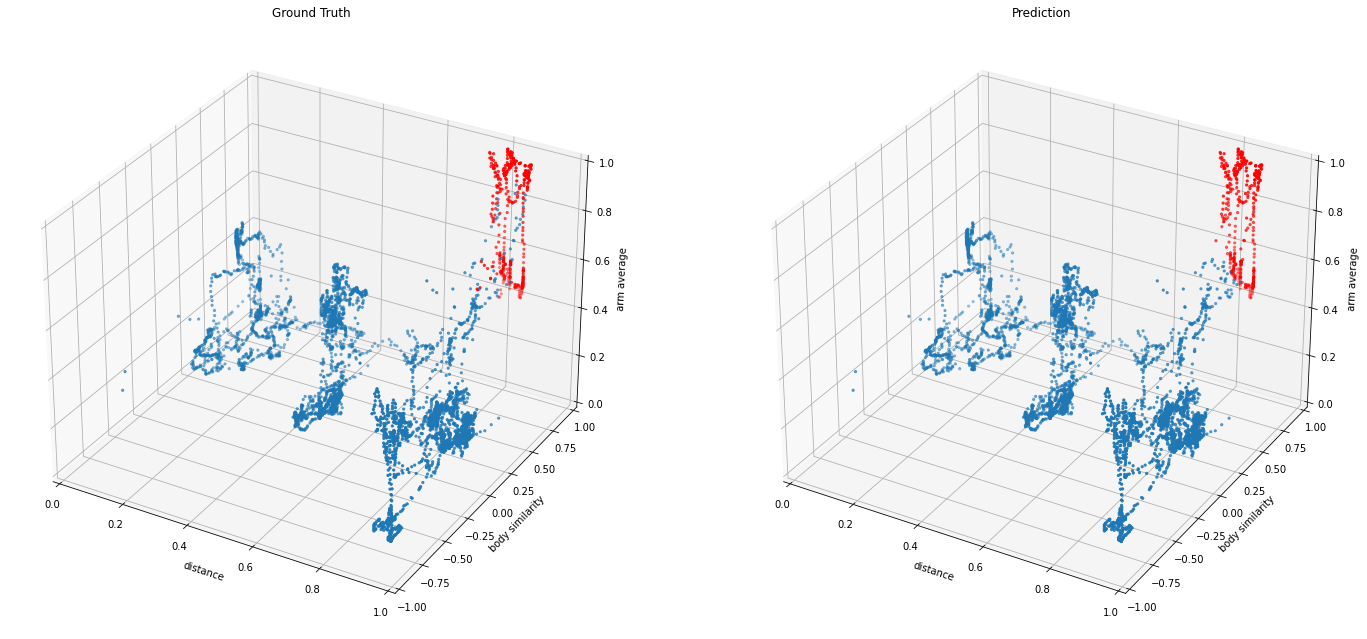

In [25]:
data_x = []
data_y = []
for x, y in zip(test_x_dict1.values(), test_y_dict1.values()):
    data_x += x
    data_y += y

gt_true = np.array(data_x)[np.where(np.array(data_y) == 1)].T
gt_false = np.array(data_x)[np.where(np.array(data_y) == 0)].T

data_x = []
for x, y in zip(test_x_dict1.values(), test_y_dict1.values()):
    data_x += x

pred_true = np.array(data_x)[np.where(np.array(test1_pred) == 1)].T
pred_false = np.array(data_x)[np.where(np.array(test1_pred) == 0)].T

# fig = plt.figure(figsize=(24, n * 6))
# ax_count = 1
# for i in range(len(columns) - 1):
#     for j in range(i + 1, len(columns)):
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 3)
#         ax.scatter(gt_false[i], gt_false[j])
#         set_ax(ax, columns[i], columns[j], 'groundtruth false')
        
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 2)
#         ax.scatter(gt_true[i], gt_true[j], color='red')
#         set_ax(ax, columns[i], columns[j], 'groundtruth true')
        
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 1)
#         ax.scatter(pred_false[i], pred_false[j])
#         set_ax(ax, columns[i], columns[j], 'pred false')
        
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 0)
#         ax.scatter(pred_true[i], pred_true[j], color='red')
#         set_ax(ax, columns[i], columns[j], 'pred true')
        
#         ax_count += 1
        
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(121, projection="3d")
ax.scatter(gt_false[0], gt_false[1], gt_false[2], marker='.')
ax.scatter(gt_true[0], gt_true[1], gt_true[2], color='red', marker='.')
ax.set_xlabel('distance')
ax.set_xlim((0, 1))
ax.set_ylabel('body similarity')
ax.set_ylim((-1, 1))
ax.set_zlabel('arm average')
ax.set_zlim((0, 1))
ax.set_title('Ground Truth')

ax = fig.add_subplot(122, projection="3d")
ax.scatter(pred_false[0], pred_false[1], pred_false[2], marker='.')
ax.scatter(pred_true[0], pred_true[1], pred_true[2], color='red', marker='.')
ax.set_xlabel('distance')
ax.set_xlim((0, 1))
ax.set_ylabel('body similarity')
ax.set_ylim((-1, 1))
ax.set_zlabel('arm average')
ax.set_zlim((0, 1))
ax.set_title('Prediction')

## テスト2

In [26]:
name_test2 = 'pass2'

In [27]:
individual_activity_json_test2 = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name_test2))
field_path = os.path.join(
    common.data_dir, 'field.png')

In [28]:
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num][0]
p_field = common.homo[room_num][1]
homo_test2 = transform.Homography(p_video, p_field, field_raw.shape)

In [29]:
individual_activity_data_test2 = json.load(individual_activity_json_test2)

In [30]:
individuals_test2 = make_individuals(individual_activity_data_test2, homo_test2)

In [31]:
csv_path = os.path.join(common.data_dir, '{0}/{1}/{2}/csv/data.csv'.format(room_num, date, name_test2))
csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

test_x_dict2 = {}
test_y_dict2 = {}
for row in csv_data:
    features = extract_features(row[1], row[2], row[0], individuals_test2)
    key = str(row[1]) + str(row[2])
    
    if key not in test_x_dict2:
        test_x_dict2[key] = []
        test_y_dict2[key] = []
        
    if features is not None:
        test_x_dict2[key].append(features)
        test_y_dict2[key].append(row[3])

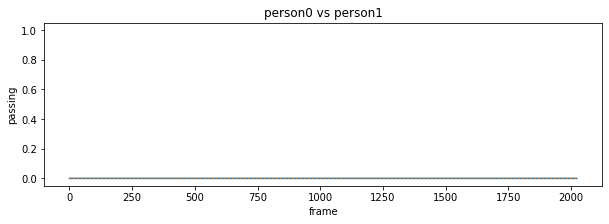

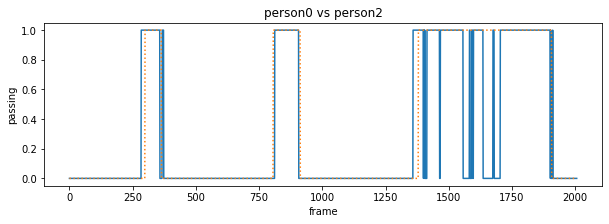

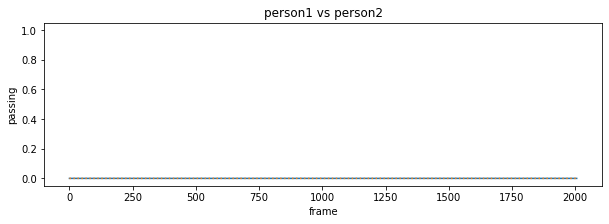

In [32]:
# test2
test2_pred = []
for persons, x, y in zip(test_x_dict2.keys(), test_x_dict2.values(), test_y_dict2.values()):
#     x = scale(x)
    pred = model.predict(x)
    test2_pred += pred.tolist()
    plt.figure(figsize=(10, 3))
    plt.plot(pred)
    plt.plot(y, linestyle=':')
    plt.ylim((-0.05, 1.05))
    plt.xlabel('frame')
    plt.ylabel('passing')
    plt.title('person{0} vs person{1}'.format(persons[0], persons[1]))
    plt.show()

accuracy: 0.971
precision: 0.929
recall: 0.810


<AxesSubplot:>

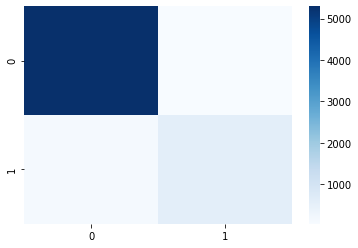

In [33]:
test_x2 = []
test_y2 = []
for x, y in zip(test_x_dict2.values(), test_y_dict2.values()):
    test_x2 += x
    test_y2 += y

pred = model.predict(test_x2)

print('accuracy: {:.3f}'.format(accuracy_score(test_y2, pred)))
print('precision: {:.3f}'.format(precision_score(test_y2, pred)))
print('recall: {:.3f}'.format(recall_score(test_y2, pred)))

cm = confusion_matrix(test_y2, pred)
sns.heatmap(cm, cmap='Blues')

Text(0.5, 0.92, 'Prediction')

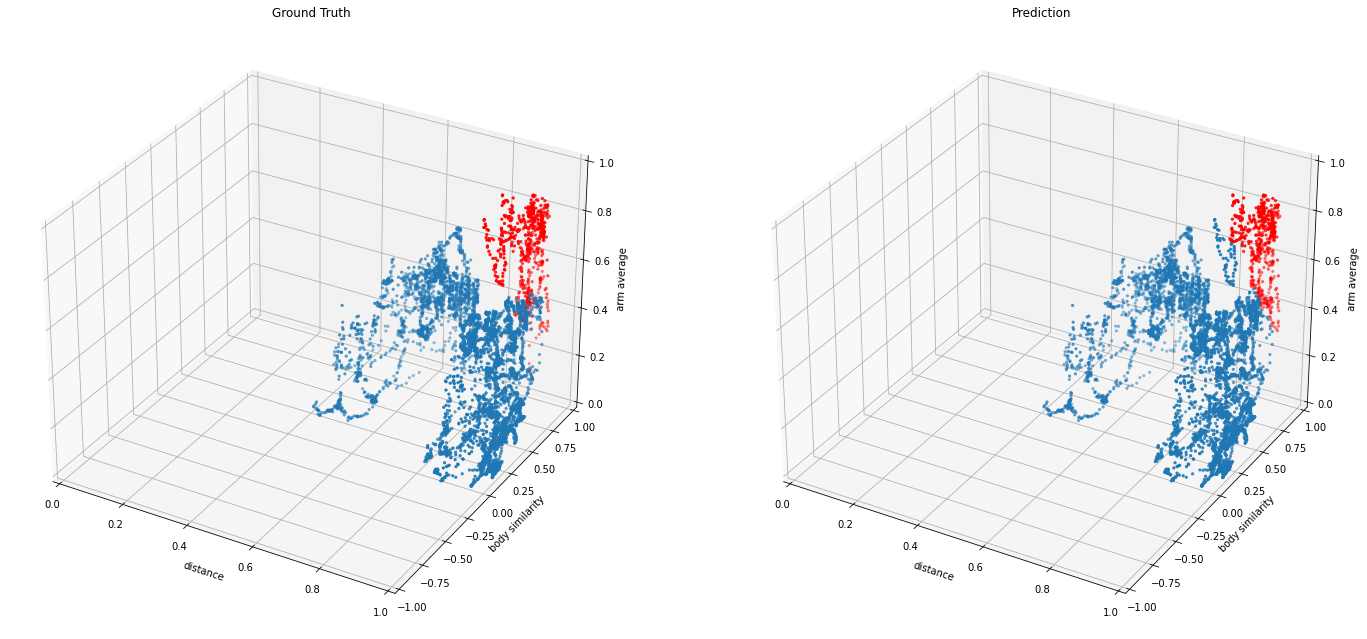

In [34]:
data_x = []
data_y = []
for x, y in zip(test_x_dict2.values(), test_y_dict2.values()):
    data_x += x
    data_y += y

gt_true = np.array(data_x)[np.where(np.array(data_y) == 1)].T
gt_false = np.array(data_x)[np.where(np.array(data_y) == 0)].T

data_x = []
for x, y in zip(test_x_dict2.values(), test_y_dict2.values()):
    data_x += x

pred_true = np.array(data_x)[np.where(np.array(test2_pred) == 1)].T
pred_false = np.array(data_x)[np.where(np.array(test2_pred) == 0)].T

# fig = plt.figure(figsize=(24, n * 6))
# ax_count = 1
# for i in range(len(columns) - 1):
#     for j in range(i + 1, len(columns)):
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 3)
#         ax.scatter(gt_false[i], gt_false[j])
#         set_ax(ax, columns[i], columns[j], 'groundtruth false')
        
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 2)
#         ax.scatter(gt_true[i], gt_true[j], color='red')
#         set_ax(ax, columns[i], columns[j], 'groundtruth true')
        
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 1)
#         ax.scatter(pred_false[i], pred_false[j])
#         set_ax(ax, columns[i], columns[j], 'pred false')
        
#         ax = fig.add_subplot(n, 4, ax_count * 4 - 0)
#         ax.scatter(pred_true[i], pred_true[j], color='red')
#         set_ax(ax, columns[i], columns[j], 'pred true')
        
#         ax_count += 1
        
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(121, projection="3d")
ax.scatter(gt_false[0], gt_false[1], gt_false[2], marker='.')
ax.scatter(gt_true[0], gt_true[1], gt_true[2], color='red', marker='.')
ax.set_xlabel('distance')
ax.set_xlim((0, 1))
ax.set_ylabel('body similarity')
ax.set_ylim((-1, 1))
ax.set_zlabel('arm average')
ax.set_zlim((0, 1))
ax.set_title('Ground Truth')

ax = fig.add_subplot(122, projection="3d")
ax.scatter(pred_false[0], pred_false[1], pred_false[2], marker='.')
ax.scatter(pred_true[0], pred_true[1], pred_true[2], color='red', marker='.')
ax.set_xlabel('distance')
ax.set_xlim((0, 1))
ax.set_ylabel('body similarity')
ax.set_ylim((-1, 1))
ax.set_zlabel('arm average')
ax.set_zlim((0, 1))
ax.set_title('Prediction')

# 境界線をプロット

In [35]:
x1 = np.linspace(0.0, 1.0, 11)
x2 = np.linspace(-1.0, 1.0, 11)
x3 = np.linspace(0.0, 1.0, 11)
x1, x2, x3 = np.meshgrid(x1, x2, x3)
data = np.stack([x1.ravel(), x2.ravel(), x3.ravel()]).T

In [36]:
pred = model.predict(data)

Text(0.5, 0, 'arm average')

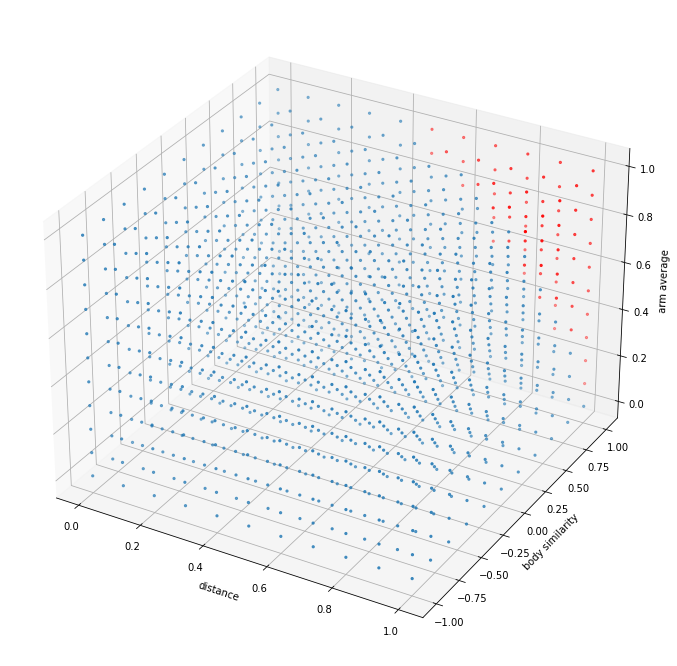

In [37]:
%matplotlib inline
true = data[pred == 1].T
false = data[pred == 0].T

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(false[0], false[1], false[2], marker='.')
ax.scatter(true[0], true[1], true[2], color='red', marker='.')
ax.set_xlabel('distance')
ax.set_ylabel('body similarity')
ax.set_zlabel('arm average')

# パラメータ調整

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [39]:
test_x = []
test_y = []
for x, y in zip(test_x_dict1.values(), test_y_dict1.values()):
    test_x += x
    test_y += y
for x, y in zip(test_x_dict2.values(), test_y_dict2.values()):
    test_x += x
    test_y += y

In [40]:
params = {
    'C': np.arange(10, 20, 1),
    'gamma': np.arange(0.01, 0.1, 0.01)
}

max_score = 0
param = {}
for c in tqdm(params['C']):
    for gamma in params['gamma']:
        model = SVC(C=c, gamma=gamma)
        model.fit(train_x, train_y)
        pred = model.predict(test_x)
        
        score = roc_auc_score(pred, test_y)
        if score > max_score:
            max_score = score
            param = {'C': c, 'gamma': gamma}
            
print('max auc score: {}, C: {}, gamma: {}'.format(max_score, param['C'], param['gamma']))

100%|██████████| 15/15 [00:54<00:00,  3.64s/it]

max auc score: 0.9605890602057415, C: 10, gamma: 0.09
